In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tqdm import trange, tqdm
import random
import cv2
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

In [2]:
TRAIN_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images'
TRAIN_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels'
VALID_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images'
VALID_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels'
TEST_IMAGE_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images'
TEST_LABEL_DIR = '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels'

TARGET_SIZE = [224, 224]

def load_images_and_labels(image_dir, label_dir):
    images = []
    class_labels = []
    polygons_list = []

    for img_name in os.listdir(image_dir):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):
            img_path = os.path.join(image_dir, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, TARGET_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Normalize
            image = image.astype(np.float32) / 255.0

            label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
            polygons = []
            classes = []

            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    lines = f.read().strip().split("\n")
                for line in lines:
                    components = line.strip().split()
                    if len(components) > 1:
                        class_id = int(components[0])
                        coords = list(map(float, components[1:]))
                        # Only keep polygons with even number of coords
                        if len(coords) % 2 == 0:
                            classes.append(class_id)
                            polygons.append(coords)

            # Decide image-level class label
            if classes:
                image_level_label = classes[0]   # or use most frequent: max(set(classes), key=classes.count)
            else:
                image_level_label = 'no_fracture'  # your 'no_fracture' label

            images.append(image)
            class_labels.append(image_level_label)
            polygons_list.append(polygons)

    return np.array(images), np.array(class_labels), polygons_list


# Load images, class labels, and polygons
train_images, train_class_labels, train_polygons = load_images_and_labels(TRAIN_IMAGE_DIR, TRAIN_LABEL_DIR)
valid_images, valid_class_labels, valid_polygons = load_images_and_labels(VALID_IMAGE_DIR, VALID_LABEL_DIR)
test_images, test_class_labels, test_polygons = load_images_and_labels(TEST_IMAGE_DIR, TEST_LABEL_DIR)

print(f"Loaded {len(train_images)} images, {len(train_class_labels)} class labels, and {len(train_polygons)} sets of polygons.")
print(f"Loaded {len(valid_images)} images, {len(valid_class_labels)} class labels, and {len(valid_polygons)} sets of polygons.")
print(f"Loaded {len(test_images)} images, {len(test_class_labels)} class labels, and {len(test_polygons)} sets of polygons.")

Loaded 3631 images, 3631 class labels, and 3631 sets of polygons.
Loaded 348 images, 348 class labels, and 348 sets of polygons.
Loaded 169 images, 169 class labels, and 169 sets of polygons.


In [3]:
# prepare CLAHE once
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

filtered_images = []
filtered_labels = []
mean_pixels = []

for img, label in zip(train_images, train_class_labels):
    # convert normalized [0,1] RGB → uint8 RGB, then to grayscale
    img_uint8 = (img * 255).astype(np.uint8)
    gray      = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    
    # apply CLAHE on the gray image
    gray_clahe = clahe.apply(gray)
    
    # compute mean on the CLAHE’d result
    mean_pixel = np.mean(gray_clahe)
    mean_pixels.append(mean_pixel)
    
    #  threshold as before
    if (mean_pixel >= 15) & (mean_pixel <= 130):
        filtered_images.append(img)
        filtered_labels.append(label)

print(f"Original images: {len(train_images)}")
print(f"Filtered images: {len(filtered_images)}")

Original images: 3631
Filtered images: 3334


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

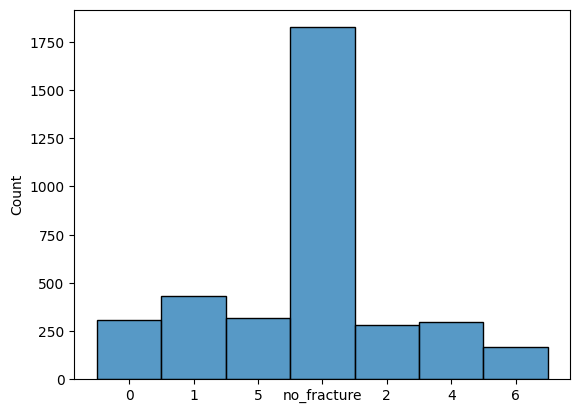

In [4]:
sns.histplot(train_class_labels)

In [5]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(filtered_labels)
valid_labels_enc = label_encoder.transform(valid_class_labels)
test_labels_enc = label_encoder.transform(test_class_labels)

print(label_encoder.classes_)  # to know the actual labels

['0' '1' '2' '4' '5' '6' 'no_fracture']


In [6]:
class_groups = defaultdict(list)

for img, label in zip(filtered_images, train_labels_enc):
    class_groups[label].append(img)

for k in class_groups:
    class_groups[k] = np.array(class_groups[k])

no_fracture_label = 6 
train_images_list, train_labels_list = [], []

for label, images in class_groups.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        train_images_list.append(images)
        train_labels_list.extend([0] * len(images))
    else:
        train_images_list.append(images)
        train_labels_list.extend([1] * len(images))

train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.array(train_labels_list)

print(np.unique(train_labels, return_counts=True))

(array([0, 1]), array([1628, 1706]))


In [7]:
class_groups_1 = defaultdict(list)

for img, label in zip(valid_images, valid_labels_enc):
    class_groups_1[label].append(img)

for k in class_groups_1:
    class_groups_1[k] = np.array(class_groups_1[k])

valid_images_list, valid_labels_list = [], []

for label, images in class_groups_1.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        valid_images_list.append(images)
        valid_labels_list.extend([0] * len(images))
    else:
        valid_images_list.append(images)
        valid_labels_list.extend([1] * len(images))

valid_images = np.concatenate(valid_images_list, axis=0)
valid_labels = np.array(valid_labels_list)

print(np.unique(valid_labels, return_counts=True))

(array([0, 1]), array([175, 173]))


In [8]:
class_groups_2 = defaultdict(list)

for img, label in zip(test_images, test_labels_enc):
    class_groups_2[label].append(img)

for k in class_groups_2:
    class_groups_2[k] = np.array(class_groups_2[k])

test_images_list, test_labels_list = [], []

for label, images in class_groups_2.items():
    if len(images) == 0:
        continue
    if label == no_fracture_label:
        test_images_list.append(images)
        test_labels_list.extend([0] * len(images))
    else:
        test_images_list.append(images)
        test_labels_list.extend([1] * len(images))

test_images = np.concatenate(test_images_list, axis=0)
test_labels = np.array(test_labels_list)

print(np.unique(test_labels, return_counts=True))

(array([0, 1]), array([86, 83]))


In [9]:
# ImageNet normalization values
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)   
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Convert and normalize
train_images_tensor = torch.tensor(train_images).permute(0, 3, 1, 2).float()
train_images_tensor = (train_images_tensor - imagenet_mean) / imagenet_std
train_labels_tensor = torch.tensor(train_labels).long()

valid_images_tensor = torch.tensor(valid_images).permute(0, 3, 1, 2).float()
valid_images_tensor = (valid_images_tensor - imagenet_mean) / imagenet_std
valid_labels_tensor = torch.tensor(valid_labels).long()

test_images_tensor = torch.tensor(test_images).permute(0, 3, 1, 2).float()
test_images_tensor = (test_images_tensor - imagenet_mean) / imagenet_std
test_labels_tensor = torch.tensor(test_labels).long()

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_images_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Set batch size
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


**Small Network**

In [10]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3),  # [batch, 64, 22, 222]
            nn.ReLU(),
            nn.MaxPool2d(2),                 # [batch, 64, 111, 111]

            nn.Conv2d(64, 128, kernel_size=3),  # [batch, 128, 109, 109]
            nn.ReLU(),
            nn.MaxPool2d(2),                   # [batch, 128, 54, 54]

            nn.Conv2d(128, 128, kernel_size=3),  # [batch, 128, 52, 52]
            nn.ReLU(),
            nn.MaxPool2d(2),                    # [batch, 128, 26, 26]

            nn.Conv2d(128, 64, kernel_size=3),   # [batch, 64, 24, 24]
            nn.ReLU(),
            nn.MaxPool2d(2),                     # [batch, 64, 12, 12]

            nn.Conv2d(64, 32, kernel_size=3),    # [batch, 32, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(2)                      # [batch, 32, 5, 5]
        )

        self.dropout = nn.Dropout(0.5)
        self.flattened_size = 32 * 5 * 5  
        self.fc1 = nn.Linear(self.flattened_size, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyCNN().to(device)

criterion = nn.BCELoss()  # Since you're using sigmoid
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [12]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.6942  Val Loss: 0.6945  Train Acc: 0.5159  Val Acc: 0.4943


Epoch 02/20 Train Loss: 0.6917  Val Loss: 0.6923  Train Acc: 0.5186  Val Acc: 0.5057


Epoch 03/20 Train Loss: 0.6912  Val Loss: 0.6901  Train Acc: 0.5330  Val Acc: 0.5230


Epoch 04/20 Train Loss: 0.6901  Val Loss: 0.6897  Train Acc: 0.5384  Val Acc: 0.5259


Epoch 05/20 Train Loss: 0.6900  Val Loss: 0.6918  Train Acc: 0.5387  Val Acc: 0.5115


Epoch 06/20 Train Loss: 0.6890  Val Loss: 0.6899  Train Acc: 0.5243  Val Acc: 0.5374


Epoch 07/20 Train Loss: 0.6878  Val Loss: 0.6868  Train Acc: 0.5369  Val Acc: 0.5374


Epoch 08/20 Train Loss: 0.6850  Val Loss: 0.6850  Train Acc: 0.5480  Val Acc: 0.5086


Epoch 09/20 Train Loss: 0.6790  Val Loss: 0.6833  Train Acc: 0.5513  Val Acc: 0.5000


Epoch 10/20 Train Loss: 0.6765  Val Loss: 0.6971  Train Acc: 0.5669  Val Acc: 0.5230


Epoch 11/20 Train Loss: 0.6811  Val Loss: 0.6825  Train Acc: 0.5519  Val Acc: 0.5201


Epoch 12/20 Train Loss: 0.6742  Val Loss: 0.6858  Train Acc: 0.5723  Val Acc: 0.5402


Epoch 13/20 Train Loss: 0.6702  Val Loss: 0.6845  Train Acc: 0.5765  Val Acc: 0.5230


Epoch 14/20 Train Loss: 0.6640  Val Loss: 0.6828  Train Acc: 0.5816  Val Acc: 0.5431


Epoch 15/20 Train Loss: 0.6573  Val Loss: 0.6823  Train Acc: 0.5966  Val Acc: 0.5517


Epoch 16/20 Train Loss: 0.6636  Val Loss: 0.6850  Train Acc: 0.5852  Val Acc: 0.5546


Epoch 17/20 Train Loss: 0.6543  Val Loss: 0.6881  Train Acc: 0.6041  Val Acc: 0.5316


Epoch 18/20 Train Loss: 0.6491  Val Loss: 0.6846  Train Acc: 0.6008  Val Acc: 0.5747


Epoch 19/20 Train Loss: 0.6473  Val Loss: 0.6780  Train Acc: 0.6038  Val Acc: 0.5546


Epoch 20/20 Train Loss: 0.6431  Val Loss: 0.6879  Train Acc: 0.6236  Val Acc: 0.5661


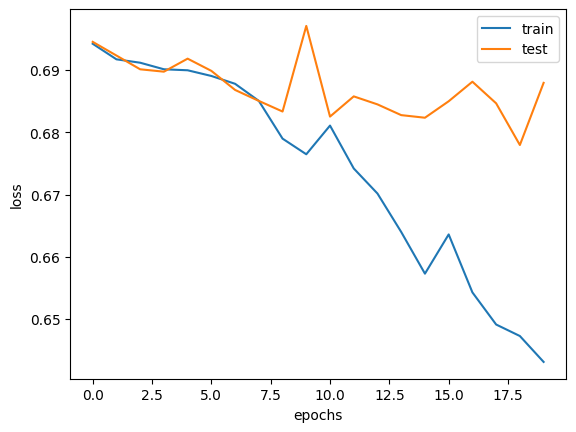

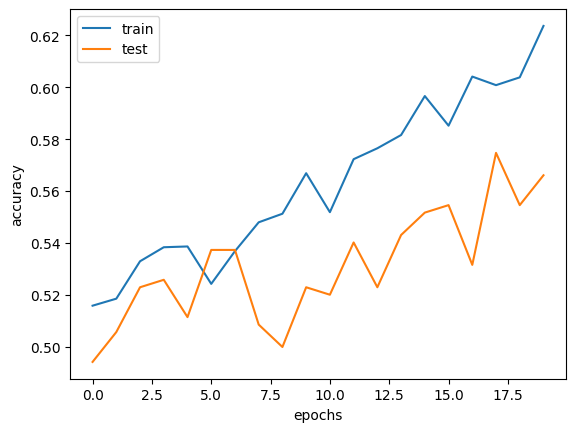

In [13]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="test")
plt.xlabel("epochs") 
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[48 38]
 [30 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59        86
           1       0.58      0.64      0.61        83

    accuracy                           0.60       169
   macro avg       0.60      0.60      0.60       169
weighted avg       0.60      0.60      0.60       169

ROC AUC: 0.5770523956290278


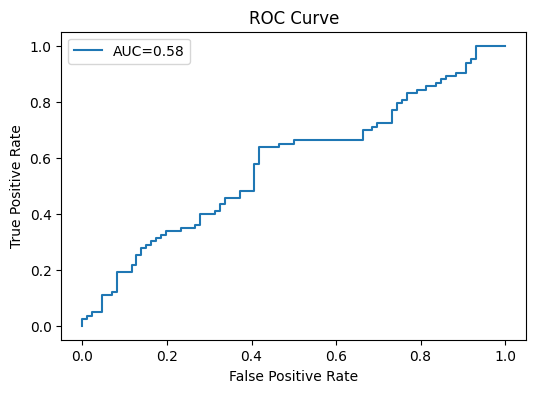

In [15]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [16]:
model = 1

**Alexnet**

In [17]:
# Load pretrained AlexNet
model = models.alexnet(pretrained=True)

# Modify the classifier for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1),
    nn.Sigmoid()  # For binary classification
)

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 214MB/s]


In [18]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.5837  Val Loss: 0.5041  Train Acc: 0.6857  Val Acc: 0.7586


Epoch 02/20 Train Loss: 0.3993  Val Loss: 0.6184  Train Acc: 0.8128  Val Acc: 0.7299


Epoch 03/20 Train Loss: 0.2621  Val Loss: 0.6251  Train Acc: 0.8890  Val Acc: 0.7385


Epoch 04/20 Train Loss: 0.1670  Val Loss: 0.8333  Train Acc: 0.9322  Val Acc: 0.7615


Epoch 05/20 Train Loss: 0.1204  Val Loss: 0.9412  Train Acc: 0.9571  Val Acc: 0.7241


Epoch 06/20 Train Loss: 0.0998  Val Loss: 1.0283  Train Acc: 0.9640  Val Acc: 0.7299


Epoch 07/20 Train Loss: 0.0714  Val Loss: 1.1533  Train Acc: 0.9739  Val Acc: 0.7586


Epoch 08/20 Train Loss: 0.0625  Val Loss: 1.2343  Train Acc: 0.9769  Val Acc: 0.7213


Epoch 09/20 Train Loss: 0.0459  Val Loss: 1.9016  Train Acc: 0.9826  Val Acc: 0.7184


Epoch 10/20 Train Loss: 0.0480  Val Loss: 2.4082  Train Acc: 0.9826  Val Acc: 0.7471


Epoch 11/20 Train Loss: 0.0578  Val Loss: 1.8262  Train Acc: 0.9805  Val Acc: 0.6810


Epoch 12/20 Train Loss: 0.0382  Val Loss: 1.6283  Train Acc: 0.9844  Val Acc: 0.7385


Epoch 13/20 Train Loss: 0.0240  Val Loss: 1.3825  Train Acc: 0.9901  Val Acc: 0.7414


Epoch 14/20 Train Loss: 0.0269  Val Loss: 1.8243  Train Acc: 0.9901  Val Acc: 0.7385


Epoch 15/20 Train Loss: 0.0173  Val Loss: 2.7048  Train Acc: 0.9946  Val Acc: 0.7069


Epoch 16/20 Train Loss: 0.0351  Val Loss: 1.6326  Train Acc: 0.9880  Val Acc: 0.7500


Epoch 17/20 Train Loss: 0.0464  Val Loss: 2.5711  Train Acc: 0.9859  Val Acc: 0.7414


Epoch 18/20 Train Loss: 0.0168  Val Loss: 1.8528  Train Acc: 0.9943  Val Acc: 0.7328


Epoch 19/20 Train Loss: 0.0180  Val Loss: 2.3588  Train Acc: 0.9946  Val Acc: 0.7385


Epoch 20/20 Train Loss: 0.0240  Val Loss: 1.9865  Train Acc: 0.9913  Val Acc: 0.7414


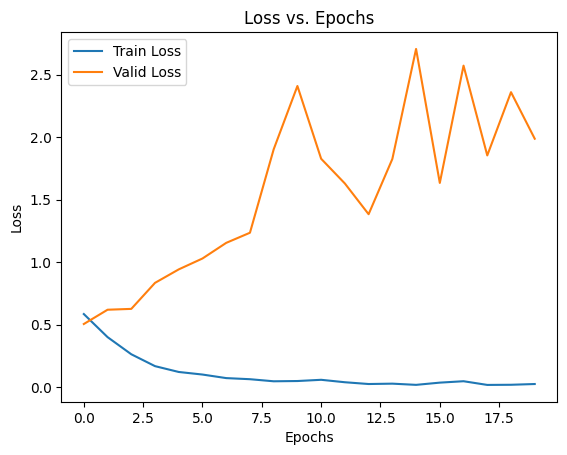

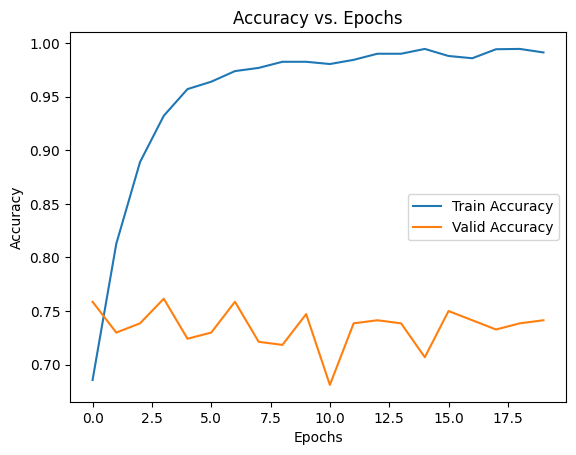

In [19]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[57 29]
 [20 63]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70        86
           1       0.68      0.76      0.72        83

    accuracy                           0.71       169
   macro avg       0.71      0.71      0.71       169
weighted avg       0.71      0.71      0.71       169

ROC AUC: 0.7974222471280471


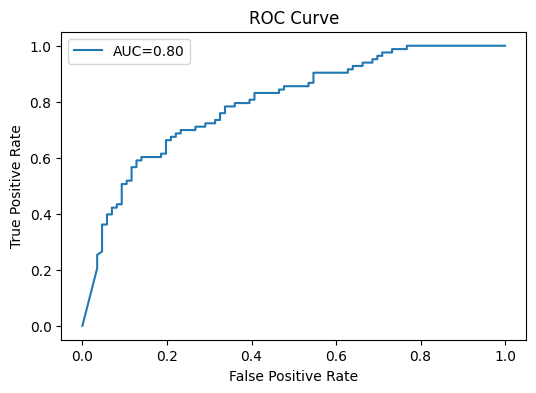

In [21]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
model = 1

**Resnet 18**

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1), 
    # nn.ReLU(),
    # nn.Dropout(0.4),
    # nn.Linear(32,16),
    # nn.ReLU(),
    # nn.Dropout(0.4),
    # nn.Linear(16,1),
    nn.Sigmoid()                 # use sigmoid to output probability
)

model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [24]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 01/20 Train Loss: 0.4855  Val Loss: 0.4628  Train Acc: 0.7603  Val Acc: 0.7787


Epoch 02/20 Train Loss: 0.1625  Val Loss: 0.6944  Train Acc: 0.9418  Val Acc: 0.7730


Epoch 03/20 Train Loss: 0.0605  Val Loss: 0.6306  Train Acc: 0.9835  Val Acc: 0.7989


Epoch 04/20 Train Loss: 0.0590  Val Loss: 0.5767  Train Acc: 0.9835  Val Acc: 0.8075


Epoch 05/20 Train Loss: 0.0321  Val Loss: 0.8948  Train Acc: 0.9910  Val Acc: 0.7529


Epoch 06/20 Train Loss: 0.0608  Val Loss: 1.0065  Train Acc: 0.9793  Val Acc: 0.7586


Epoch 07/20 Train Loss: 0.0451  Val Loss: 0.8046  Train Acc: 0.9835  Val Acc: 0.7845


Epoch 08/20 Train Loss: 0.0462  Val Loss: 0.7697  Train Acc: 0.9835  Val Acc: 0.7902


Epoch 09/20 Train Loss: 0.0264  Val Loss: 0.8467  Train Acc: 0.9931  Val Acc: 0.7902


Epoch 10/20 Train Loss: 0.0449  Val Loss: 0.7119  Train Acc: 0.9865  Val Acc: 0.8132


Epoch 11/20 Train Loss: 0.0076  Val Loss: 0.6227  Train Acc: 0.9991  Val Acc: 0.8333


Epoch 12/20 Train Loss: 0.0024  Val Loss: 0.6458  Train Acc: 1.0000  Val Acc: 0.8305


Epoch 13/20 Train Loss: 0.0024  Val Loss: 0.6611  Train Acc: 1.0000  Val Acc: 0.8218


Epoch 14/20 Train Loss: 0.0119  Val Loss: 0.6793  Train Acc: 0.9955  Val Acc: 0.8132


Epoch 15/20 Train Loss: 0.0117  Val Loss: 0.6616  Train Acc: 0.9964  Val Acc: 0.8247


Epoch 16/20 Train Loss: 0.0208  Val Loss: 0.8100  Train Acc: 0.9934  Val Acc: 0.8190


Epoch 17/20 Train Loss: 0.0114  Val Loss: 0.7415  Train Acc: 0.9964  Val Acc: 0.8333


Epoch 18/20 Train Loss: 0.0475  Val Loss: 0.8950  Train Acc: 0.9922  Val Acc: 0.7989


Epoch 19/20 Train Loss: 0.1014  Val Loss: 0.7989  Train Acc: 0.9664  Val Acc: 0.7701


Epoch 20/20 Train Loss: 0.0192  Val Loss: 0.8479  Train Acc: 0.9925  Val Acc: 0.8075


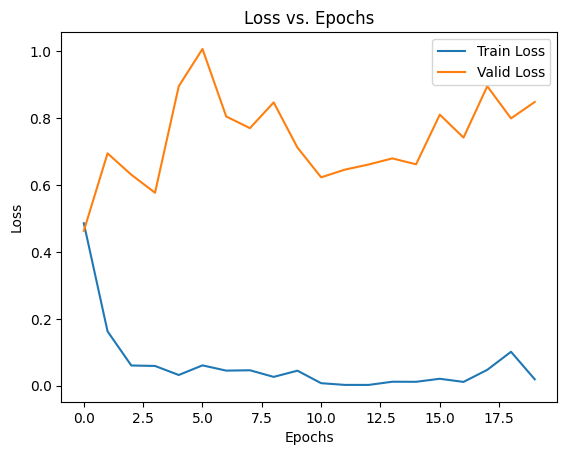

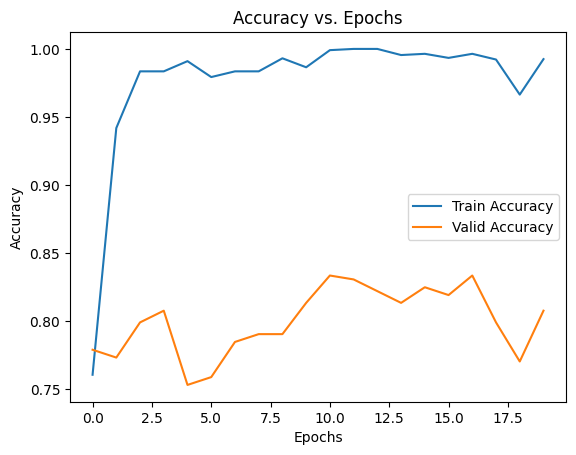

In [25]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[73 13]
 [23 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80        86
           1       0.82      0.72      0.77        83

    accuracy                           0.79       169
   macro avg       0.79      0.79      0.79       169
weighted avg       0.79      0.79      0.79       169

ROC AUC: 0.8715326421966938


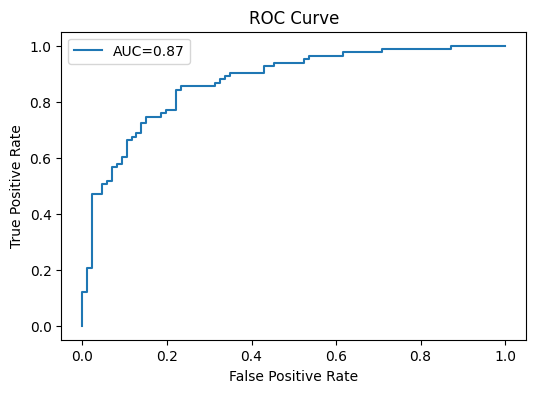

In [27]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [28]:
model = 1

**EfficientNetB0**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(16,1),
    nn.Sigmoid() 
)

model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch 01/20 Train Loss: 0.6304  Val Loss: 0.5106  Train Acc: 0.6350  Val Acc: 0.7730


Epoch 02/20 Train Loss: 0.4484  Val Loss: 0.4317  Train Acc: 0.8107  Val Acc: 0.8161


Epoch 03/20 Train Loss: 0.2882  Val Loss: 0.5045  Train Acc: 0.9043  Val Acc: 0.7902


Epoch 04/20 Train Loss: 0.1772  Val Loss: 0.5679  Train Acc: 0.9451  Val Acc: 0.7902


Epoch 05/20 Train Loss: 0.1070  Val Loss: 0.7125  Train Acc: 0.9709  Val Acc: 0.7672


Epoch 06/20 Train Loss: 0.1392  Val Loss: 0.6865  Train Acc: 0.9613  Val Acc: 0.8276


Epoch 07/20 Train Loss: 0.1070  Val Loss: 0.7568  Train Acc: 0.9694  Val Acc: 0.7902


Epoch 08/20 Train Loss: 0.0818  Val Loss: 0.6749  Train Acc: 0.9796  Val Acc: 0.8017


Epoch 09/20 Train Loss: 0.0514  Val Loss: 0.7000  Train Acc: 0.9898  Val Acc: 0.8190


Epoch 10/20 Train Loss: 0.1034  Val Loss: 0.8639  Train Acc: 0.9715  Val Acc: 0.7931


Epoch 11/20 Train Loss: 0.0553  Val Loss: 0.8162  Train Acc: 0.9862  Val Acc: 0.8132


Epoch 12/20 Train Loss: 0.0385  Val Loss: 0.9124  Train Acc: 0.9913  Val Acc: 0.8132


Epoch 13/20 Train Loss: 0.0281  Val Loss: 1.1148  Train Acc: 0.9940  Val Acc: 0.7816


Epoch 14/20 Train Loss: 0.0843  Val Loss: 0.7707  Train Acc: 0.9787  Val Acc: 0.8190


Epoch 15/20 Train Loss: 0.0292  Val Loss: 0.8531  Train Acc: 0.9919  Val Acc: 0.8305


Epoch 16/20 Train Loss: 0.0508  Val Loss: 1.0318  Train Acc: 0.9859  Val Acc: 0.8017


Epoch 17/20 Train Loss: 0.0474  Val Loss: 1.2002  Train Acc: 0.9895  Val Acc: 0.7529


Epoch 18/20 Train Loss: 0.0224  Val Loss: 0.9180  Train Acc: 0.9955  Val Acc: 0.8276


Epoch 19/20 Train Loss: 0.0823  Val Loss: 1.2699  Train Acc: 0.9892  Val Acc: 0.7960


Epoch 20/20 Train Loss: 0.1322  Val Loss: 0.8707  Train Acc: 0.9739  Val Acc: 0.7960


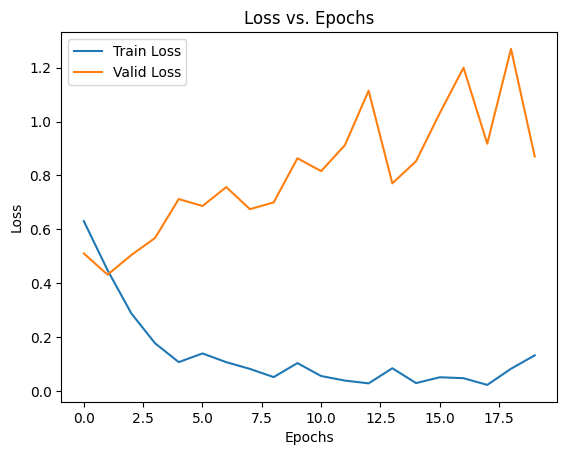

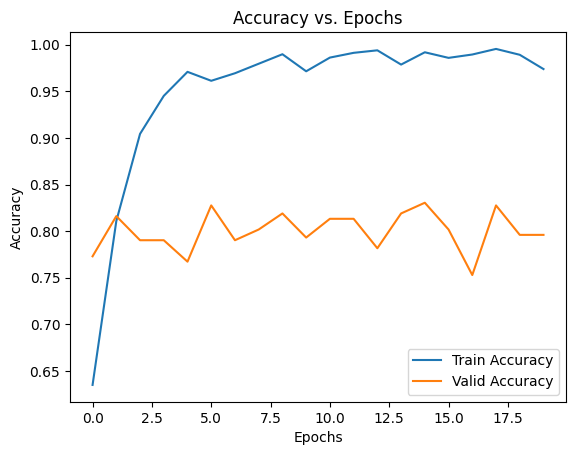

In [31]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[72 14]
 [27 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        86
           1       0.80      0.67      0.73        83

    accuracy                           0.76       169
   macro avg       0.76      0.76      0.76       169
weighted avg       0.76      0.76      0.76       169

ROC AUC: 0.8592042588960493


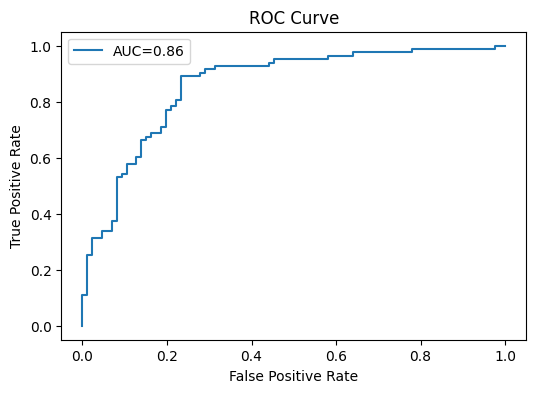

In [33]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [34]:
model = 1

**ResNet152**

In [35]:
model = models.resnet152(pretrained=True)

# Replace the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  # One output for binary classification
    nn.Sigmoid()                         # Because you're using nn.BCELoss()
)

model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 223MB/s]


In [36]:
num_epochs = 20

# Trackers for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=f"{total_train_loss / len(train_bar):.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False)
    with torch.no_grad():
        for val_images, val_labels in val_bar:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            total_val_loss += val_loss.item()

            preds = (val_outputs > 0.5).float()
            correct_val += (preds == val_labels).sum().item()
            total_val += val_labels.size(0)

            val_bar.set_postfix(loss=f"{total_val_loss / len(val_bar):.4f}",
                                acc=f"{correct_val / total_val:.4f}")

    avg_val_loss = total_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Final summary print
    print(f"Epoch {epoch+1:02}/{num_epochs} "
          f"Train Loss: {avg_train_loss:.4f}  "
          f"Val Loss: {avg_val_loss:.4f}  "
          f"Train Acc: {train_accuracy:.4f}  "
          f"Val Acc: {val_accuracy:.4f}")

Epoch 01/20 Train Loss: 0.4301  Val Loss: 0.4680  Train Acc: 0.7945  Val Acc: 0.7845


Epoch 02/20 Train Loss: 0.1704  Val Loss: 0.6472  Train Acc: 0.9343  Val Acc: 0.7989


Epoch 03/20 Train Loss: 0.0949  Val Loss: 0.6808  Train Acc: 0.9631  Val Acc: 0.8190


Epoch 04/20 Train Loss: 0.0679  Val Loss: 0.6218  Train Acc: 0.9790  Val Acc: 0.7960


Epoch 05/20 Train Loss: 0.0508  Val Loss: 0.5549  Train Acc: 0.9826  Val Acc: 0.8333


Epoch 06/20 Train Loss: 0.0302  Val Loss: 0.6449  Train Acc: 0.9907  Val Acc: 0.8247


Epoch 07/20 Train Loss: 0.0549  Val Loss: 0.6362  Train Acc: 0.9823  Val Acc: 0.8132


Epoch 08/20 Train Loss: 0.0601  Val Loss: 0.6001  Train Acc: 0.9811  Val Acc: 0.8391


Epoch 09/20 Train Loss: 0.0728  Val Loss: 0.6504  Train Acc: 0.9730  Val Acc: 0.8103


Epoch 10/20 Train Loss: 0.0197  Val Loss: 0.6697  Train Acc: 0.9934  Val Acc: 0.8333


Epoch 11/20 Train Loss: 0.0137  Val Loss: 0.5855  Train Acc: 0.9973  Val Acc: 0.8333


Epoch 12/20 Train Loss: 0.0066  Val Loss: 0.5936  Train Acc: 0.9985  Val Acc: 0.8218


Epoch 13/20 Train Loss: 0.0134  Val Loss: 0.6788  Train Acc: 0.9994  Val Acc: 0.8420


Epoch 14/20 Train Loss: 0.0672  Val Loss: 0.7012  Train Acc: 0.9766  Val Acc: 0.8247


Epoch 15/20 Train Loss: 0.0145  Val Loss: 0.6099  Train Acc: 0.9973  Val Acc: 0.8362


Epoch 16/20 Train Loss: 0.0039  Val Loss: 0.7063  Train Acc: 0.9994  Val Acc: 0.8305


Epoch 17/20 Train Loss: 0.0011  Val Loss: 0.6311  Train Acc: 1.0000  Val Acc: 0.8305


Epoch 18/20 Train Loss: 0.0005  Val Loss: 0.6411  Train Acc: 1.0000  Val Acc: 0.8448


Epoch 19/20 Train Loss: 0.0004  Val Loss: 0.6805  Train Acc: 1.0000  Val Acc: 0.8448


Epoch 20/20 Train Loss: 0.0003  Val Loss: 0.6651  Train Acc: 1.0000  Val Acc: 0.8477


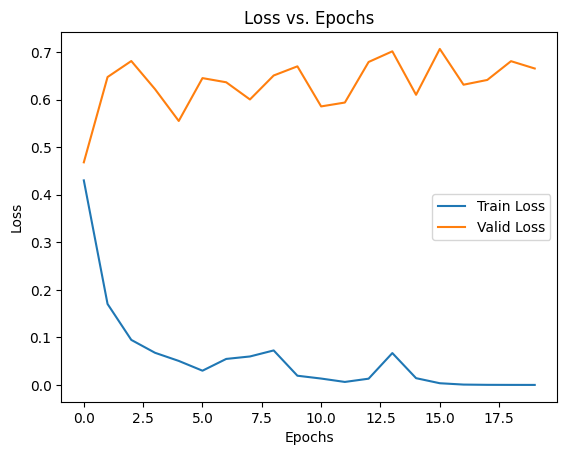

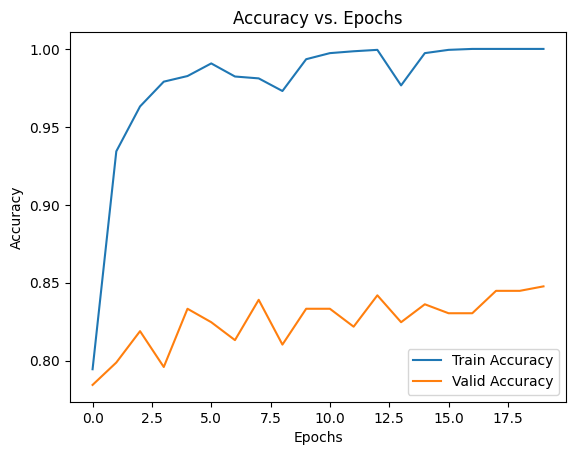

In [37]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Valid Loss")
plt.title('Loss vs. Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Valid Accuracy")
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [38]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

pred_labels = (np.array(all_preds) > 0.5).astype(int)
true_labels = np.array(all_labels).astype(int)

Confusion Matrix:
 [[75 11]
 [21 62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82        86
           1       0.85      0.75      0.79        83

    accuracy                           0.81       169
   macro avg       0.82      0.81      0.81       169
weighted avg       0.81      0.81      0.81       169

ROC AUC: 0.9030540767722051


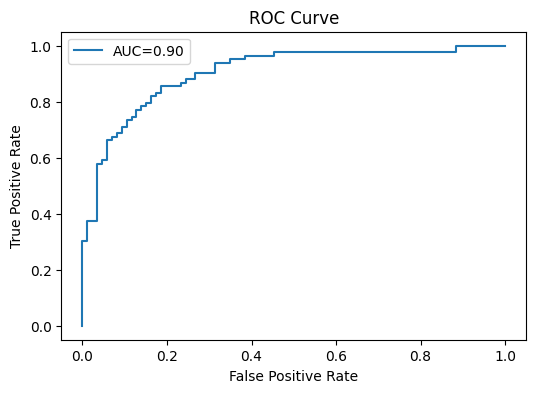

In [39]:
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))
print("ROC AUC:", roc_auc_score(true_labels, all_preds))

# ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, all_preds)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(true_labels, all_preds):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()